In [51]:
# todo: work on imports
import sys
sys.path.append("../")
from mir.common import parser, Repertoire, SegmentLibrary
from mir.distances import ClonotypeAligner, AlignGermline
from mir.comparative import DenseMatch

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

Load prototypes

In [52]:
lib = SegmentLibrary.load_default()
db = Repertoire(parser.parse_olga('assets/olga_humanTRB.txt', lib=lib, n=1000))
print(db)

Repertoire of 1000 clonotypes and 1000 cells:
Clonotype 0 CASSWGKGRGLRTDTQYF TGCGCCAGCAGCTGGGGAAAGGGGAGGGGCCTCCGCACAGATACGCAGTATTTT
Clonotype 1 CASSIIVRGIQNTEAFF TGTGCCAGTAGTATTATCGTCAGGGGGATTCAGAACACTGAAGCTTTCTTT
Clonotype 2 CASSLAWGPRNQPQHF TGTGCCAGCAGTTTAGCTTGGGGACCCCGCAATCAGCCCCAGCATTTT
Clonotype 3 CASSLARGAYEQYF TGCGCCAGCAGCTTGGCTCGGGGGGCCTACGAGCAGTACTTC
Clonotype 4 CASSQAVLYEKLFF TGCGCCAGCAGCCAGGCGGTACTTTATGAAAAACTGTTTTTT
...


Load VDJdb excl. 10X

In [53]:
tenxref = "https://www.10xgenomics.com/resources/application-notes/a-new-way-of-exploring-immunity-linking-highly-multiplexed-antigen-recognition-to-immune-repertoire-and-phenotype/#"
data = parser.parse_vdjdb_slim('assets/vdjdb.slim.txt', lib=lib, gene='TRB', species='HomoSapiens', 
                               warn=False, 
                               filter=lambda x: x[x['reference.id'] != tenxref])
data = [x for x in data if len(x.cdr3aa) in range(7, 23)]
#data = data[0:1000]
print(data[0:10])
len(data)

[Clonotype 7 CASSAFPCREGRNNEQFF, Clonotype 13 CASSHGVGQGPYEQYF, Clonotype 14 CASSLTTESGEQYF, Clonotype 26 CASSLGTLEETQYF, Clonotype 34 CASIPEGGRETQYF, Clonotype 43 CASSLDSLNTIYF, Clonotype 44 CASSQDTASSYEQYF, Clonotype 48 CASSLSYRGNSPLHF, Clonotype 58 CSADGLPISSYNEQFF, Clonotype 59 CASTRADTGELFF]


23714

Initialize aligners

In [54]:
valign = AlignGermline.from_seqs(lib.get_seqaas(gene='TRB', stype='V'))
jalign = AlignGermline.from_seqs(lib.get_seqaas(gene='TRB', stype='J'))
aligner = ClonotypeAligner(v_aligner=valign, j_aligner=jalign)
matcher = DenseMatch(db, aligner)

Test class methods

In [55]:
print(''.join(str(x) for x in matcher.match_single(data[0])))
print([m.__dict__() for m in matcher.match_single(data[0])])
print([m.__dict__() for m in matcher.match(data[0:1])])
print(matcher.match_to_df(data[0:10]))

(v:168.0,j:62.0,cdr3:-200.0)(v:269.0,j:40.0,cdr3:-900.0)(v:303.0,j:44.0,cdr3:-900.0)(v:168.0,j:59.0,cdr3:-900.0)(v:168.0,j:40.0,cdr3:-100.0)(v:266.0,j:48.0,cdr3:-800.0)(v:150.0,j:34.0,cdr3:-1300.0)(v:148.0,j:42.0,cdr3:-1100.0)(v:283.0,j:48.0,cdr3:-500.0)(v:145.0,j:50.0,cdr3:-1200.0)(v:162.0,j:85.0,cdr3:-900.0)(v:283.0,j:59.0,cdr3:-1500.0)(v:148.0,j:59.0,cdr3:-200.0)(v:165.0,j:34.0,cdr3:1400.0)(v:171.0,j:62.0,cdr3:-300.0)(v:266.0,j:59.0,cdr3:-1400.0)(v:269.0,j:44.0,cdr3:900.0)(v:107.0,j:48.0,cdr3:-400.0)(v:107.0,j:40.0,cdr3:-100.0)(v:283.0,j:59.0,cdr3:-600.0)(v:413.0,j:40.0,cdr3:200.0)(v:135.0,j:40.0,cdr3:100.0)(v:145.0,j:62.0,cdr3:-600.0)(v:339.0,j:34.0,cdr3:-1400.0)(v:145.0,j:41.0,cdr3:-1300.0)(v:144.0,j:40.0,cdr3:-800.0)(v:135.0,j:44.0,cdr3:-700.0)(v:171.0,j:41.0,cdr3:-100.0)(v:145.0,j:35.0,cdr3:700.0)(v:107.0,j:59.0,cdr3:-1200.0)(v:142.0,j:85.0,cdr3:-500.0)(v:501.0,j:59.0,cdr3:-2300.0)(v:153.0,j:59.0,cdr3:-200.0)(v:144.0,j:59.0,cdr3:100.0)(v:501.0,j:40.0,cdr3:-900.0)(v:283.0,j:48.0,

In [56]:
res = matcher.match_to_df(data, 10, 10)
np.shape(res)

(0.9, 100)

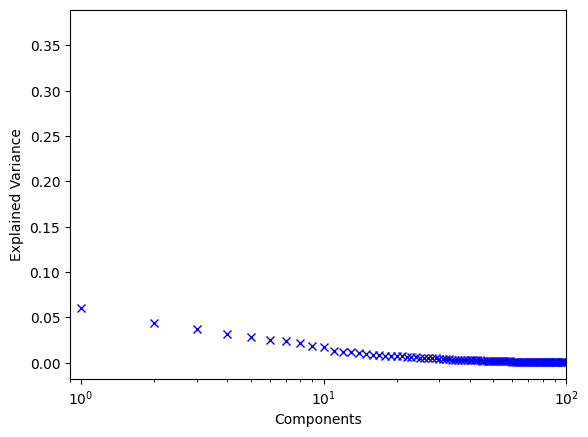

In [ ]:
pca = PCA(n_components=100, whiten=True)
pca.fit(res.iloc[:,1:])

plt.plot(pca.explained_variance_ratio_, 'bx')
plt.xscale('log')
plt.ylabel('Explained Variance')
plt.xlabel('Components')
plt.xlim(.9, pca.n_components_)

Text(0.5, 1.0, 'Joining gene')

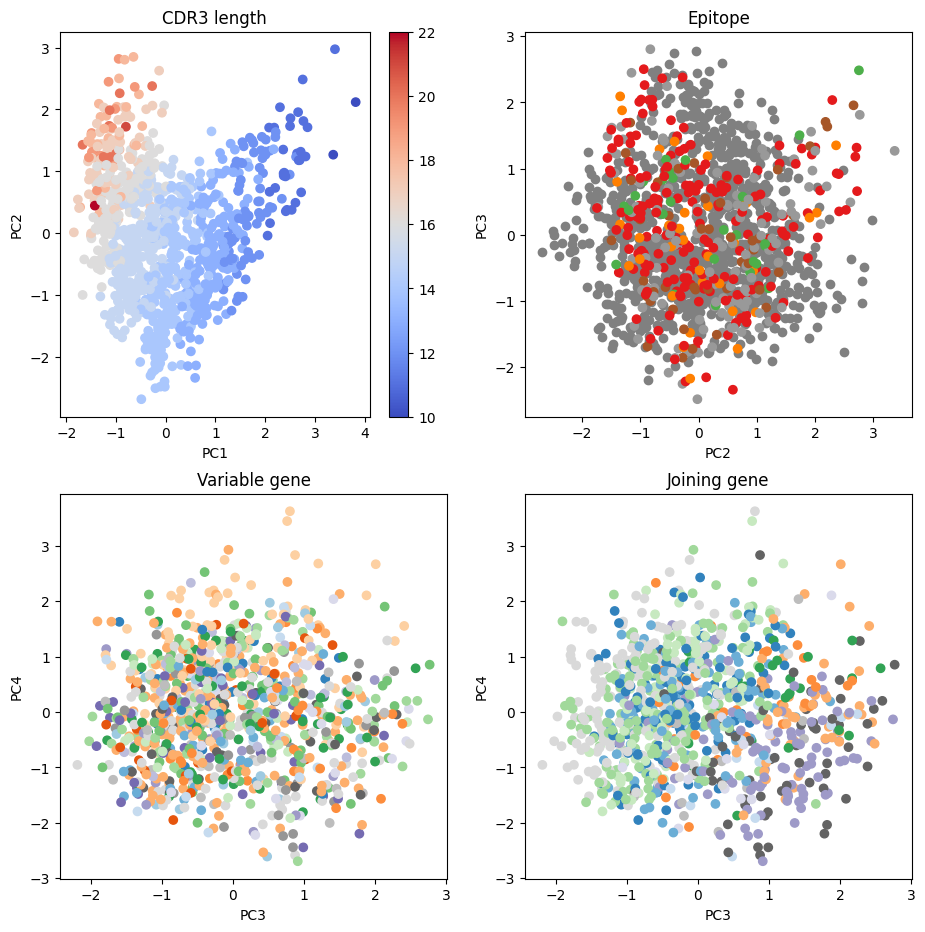

In [ ]:
v_fac = {v: i for i, v in enumerate(sorted(set(x.v.id for x in data)))}
j_fac = {j: i for i, j in enumerate(sorted(set(x.j.id for x in data)))}
epi = [x.payload['vdjdb'].epitope for x in data] # todo - make (dot)vdjdb not ['vdjdb']
epi = [x for x, count in Counter(epi).items() if count >= 30]
epi_fac = {j: i for i, j in enumerate(epi)}
epi_x = [epi_fac.get(x.payload['vdjdb'].epitope, -1) for x in data]
good_epi_ids = [i for (i, x) in enumerate(epi_x) if x >= 0]
res_rot = pca.transform(res.iloc[:,1:])

fig, axs = plt.subplots(2, 2, figsize=(11, 11))
p0 = axs[0, 0].scatter(res_rot[:, 0], res_rot[:, 1], c=[len(x.cdr3aa) for x in data], cmap='coolwarm')
axs[0, 0].set_xlabel('PC1')
axs[0, 0].set_ylabel('PC2')
axs[0, 0].set_title('CDR3 length')
fig.colorbar(p0)

axs[0, 1].scatter(res_rot[:, 1], res_rot[:, 2], 
            c='grey')
axs[0, 1].scatter(res_rot[good_epi_ids, 0], res_rot[good_epi_ids, 1], 
            c=[epi_x[i] for i in good_epi_ids], 
            cmap='Set1')
axs[0, 1].set_xlabel('PC2')
axs[0, 1].set_ylabel('PC3')
axs[0, 1].set_title('Epitope')

axs[1, 0].scatter(res_rot[:, 2], res_rot[:, 3], 
            c=[v_fac[x.v.id] for x in data], 
            cmap='tab20c')
axs[1, 0].set_xlabel('PC3')
axs[1, 0].set_ylabel('PC4')
axs[1, 0].set_title('Variable gene')

axs[1, 1].scatter(res_rot[:, 2], res_rot[:, 3], 
            c=[j_fac[x.j.id] for x in data], 
            cmap='tab20c')
axs[1, 1].set_xlabel('PC3')
axs[1, 1].set_ylabel('PC4')
axs[1, 1].set_title('Joining gene')


#import matplotlib.cm
#def get_cmap_string(palette, domain):
#    domain_unique = np.unique(domain)
#    hash_table = {key: i_str for i_str, key in enumerate(domain_unique)}
 #   mpl_cmap = matplotlib.cm.get_cmap(palette, lut=len(domain_unique))
#
#    def cmap_out(X, **kwargs):
#        return mpl_cmap(hash_table[X], **kwargs)
#
#    return cmap_out

#v_uniq = get_cmap_string
#colors = cmap(np.linspace(0, 1, len(names)))